In [1]:
from pathlib import Path
import os
import json
import sys
import optuna
from optuna.samplers import TPESampler
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import ProgressBarCallback
import numpy as np
import torch
import random
import yaml
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
path_to_src = Path(Path(os.getcwd()).parent, 'src')
sys.path.append(str(path_to_src))
from enviroment import StockTradingEnvDSR
from agents import LinearFeatureExtractor, RNNFeatureExtractor, LSTMExtractor, MLPFeatureExtractor
from utils import get_data, get_scaled_data_new, get_time_data_new, prepare_aligned_data, daily_portfolio_return, statistics_calc
import warnings
warnings.filterwarnings('ignore')

# Reinforcement Learning (RL) in algorithmic trading

В контролируемом обучении (Supervised learning) мы хотим предсказать метку (target), используя набор признаков (предикторов), и мы обучаем модель МО, используя множество выборок пар (признаки, метка). В обучении с подкреплением (RL) мы хотим максимизировать цель, используя последовательность действий (поэтому это иногда называют «последовательным принятием решений»). Каждое действие $a(t)$ в момент времени $t$ основано на переменных состояния $s(t)$ в момент времени $t$, и следующее состояние $s(t+1)$ может (но не обязательно) зависеть от $s(t)$ и $a(t)$. в общем случае и $a$, и $s$ могут быть векторами или даже матрицами. Переменные состояния в RL соответствуют признакам в контролируемом обучении. После того, как действие $a(t)$ выполнено, мы получаем награду $r(t)$, скаляр. В простейшем случае (например, в рассматриваемом нами примере) конечной целью является максимизация ожидаемого общего вознаграждения:
$$J = E[r(0) + r(1) + ... + r(T)]$$
Модель ML в глубоком обучении с подкреплением (DRL) используется для обучения на последовательности $(s(t), a(t), r(t))$ для $t=0, 1, 2, …,$ чтобы сгенерировать оптимальное $a(t)$ с учетом входных данных $s(t)$, с целью максимизировать $J$. В теории принято называть эту модель ML политикой $\pi$. Важно отметить, что $\pi$ — это распределение вероятностей по действиям, обусловленным состояниями, $\pi( a(t) | s(t) )$. Действие не является детерминированной функцией состояния. Именно поэтому цель DRL — максимизировать ожидаемую общую награду, а не реализованную общую награду из одной выборочной последовательности $(s(t), a(t), r(t))$.
$$
\pi^* = \text{argmax}_\pi J(\pi) = \text{argmax}_\pi \mathbb{E} \left[ \sum_{t=0}^T r(s_t, a_t \sim \pi(a|s_t)) \right] \tag{1}
$$

где $\sim$ означает, что действие $a$ выбирается из распределения вероятностей $\pi(a(t)|s(t))$. Для упрощения записи мы использовали $s$ и $a$ для обозначения $s(t)$ и $a(t)$.

### Q-learning

Q-learning - алгоритм обучения с подкреплением (RL), где агент учится **оптимальной стратегии** через оценку функции качества действий. Ключевые понятия:

- **Q-функция** $Q(s,a)$: Ожидаемая суммарная дисконтированная награда за выбор действия $a$ в состоянии $s$ с последующим следованием оптимальной политике
- **V-функция** $V(s)$: Ожидаемая суммарная награда из состояния $s$ при оптимальной политике ($V(s) = \max_a Q(s,a)$)
- **Связь Q и V**: $Q(s,a) = r(s,a) + \gamma \mathbb{E}[V(s')]$
  
$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right) \tag{1}
$$

где:
- $\alpha$ — скорость обучения
- $\gamma$ — коэффициент дисконтирования
- $r_t$ — награда на шаге $t$

Используется $\epsilon$-greedy стратегия исследования:
- С вероятностью $\epsilon$ выбирается случайное действие
- Иначе выбирается действие $\argmax_a Q(s_t, a)$

Полная будущая награда определяется как:

$$
R_\Sigma = r_t + \gamma V(s_{t+1}) \tag{2}
$$

Обобщение на $n$ шагов (n-step return):

$$
R_\Sigma^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k} + \gamma^n \max_a Q(s_{t+n}, a) \tag{3}
$$

При параметризации Q-функции нейросетью $Q_\theta$ получаем:

$$
Q_\theta(s_t, a_t) \leftarrow Q_\theta(s_t, a_t) + \alpha \left( R_\Sigma^{(n)} - Q_\theta(s_t, a_t) \right) \tag{4}
$$

где целевое значение вычисляется как:

$$
R_\Sigma^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k} + \gamma^n \max_a Q_{\theta^-}(s_{t+n}, a) \tag{5}
$$

Здесь $\theta^-$ — параметры целевой сети (target network).

### Proximal Policy Optimization (PPO)

#### 1. Обновление политики через градиентный спуск  
В Reinforcement Learning цель — максимизировать суммарную вознаграждение агента. Прямая оптимизация параметров политики  
$
\pi_\theta(a \mid s)
$
методом градиентного спуска может приводить к слишком резким изменениям стратегии и дестабилизации обучения.

---

#### 2. Вероятностное отношение (Probability Ratio)  
Чтобы измерять, насколько новая политика отличается от старой, вводят отношение вероятностей:
$$
r(\theta) = \frac{\pi_\theta(a \mid s)}{\pi_{\theta_\text{old}}(a \mid s)}
$$
- Если $r(\theta)$ сильно уходит от 1, новая политика слишком далека от предыдущей.  
- Контроль «размашистых» обновлений помогает сохранить стабильность обучения.

---

#### 3. Оценка преимущества (Advantage Estimate)  
Преимущество $A_t$ показывает, насколько действие превзошло ожидания:
$$
A_t = R_t - V(s_t)
$$ 
- $R_t$ — накопленная дисконтированная награда с момента $t$.  
- $V(s_t)$ — оценка ценности состояния $s_t$.  
- $A_t>0$ указывает на действия лучше среднего, $A_t<0$ — хуже.

---

#### 4. Механизм «clipping»  
Чтобы предотвратить слишком большие шаги, используют «обрезку» отношения:
$$
L(\theta) = \mathbb{E}\bigl[\min\bigl(r(\theta)\,A_t,\;\mathrm{clip}\bigl(r(\theta),\,1-\varepsilon,\,1+\varepsilon\bigr)\,A_t\bigr)\bigr]
$$  
- $\varepsilon\in[0.1,0.3]$ задаёт допустимый диапазон изменений $r(\theta)$.  
- Если $r(\theta)$ выходит за границы $[1-\varepsilon,\,1+\varepsilon]$, сигнализируется «слишком резкое» обновление и соответствующий вклад в функцию потерь ограничивается.

---

#### 5. Итоговый процесс обучения PPO  
1. **Сбор траекторий** по текущей политике $\pi_{\theta_\text{old}}$.  
2. **Оценка преимуществ** $A_t$ с помощью ценностной функции $V(s)$.  
3. **Оптимизация** обновлённой политики $\pi_\theta$ с функцией потерь $L(\theta)$ и механизмом clipping.  
4. **Обновление** старых параметров: $\theta_\text{old}\gets\theta$.  
5. **Повторение цикла** до сходимости.


### Используемые алгоритмы и модели

В своей реализации я опирался на готовые реализации из библиотеки [Stable Baselines 3](https://github.com/DLR-RM/stable-baselines3):

- **DQN**  
- **PPO**

#### Репозиторий с кодом  
Все файлы с окружением и агентами лежат по ссылке:  
> https://github.com/VladShchekotikhin/rl_study

---

#### Параметризация Q‑функции в DQN

Для DQN рассматривались три разных экстрактора признаков (feature extractors), каждый из которых задаёт свою архитектуру аппроксимации $Q(s,a)$:

1. **LinearFeatureExtractor**  
   - Свёртка всего окна наблюдений в вектор длины `features_dim`.  
   - Состоит из одного линейного слоя + активации Tanh.  
2. **RNNFeatureExtractor**
   - Состоит из одного реккурентного слоя $\text{RNN}$ и одного линейного.
   - Из-за своей реккурентной структуры должна лучше улавливать временные зависимости.
3. **LSTMExtractor**
   - Состоит из одного реккурентного слоя $\text{LSTM}$ и одного линейного.
   - Из-за своей реккурентной структуры должна лучше улавливать временные зависимости.

### Функция награды: Дифференциальный коэффициент Шарпа (DSR)

В задачах алгоритмической торговли стандартная максимизация прибыли часто приводит к неоптимальным результатам, так как не учитывает риск. Современные управляющие портфелем максимизируют **риск-скорректированную доходность**. Для этого обычно используется коэффициент Шарпа, но он имеет ограничение: требует расчета за фиксированный период времени $T$, что делает его непригодным для онлайн-обучения.

В качестве решения мы используем **Дифференциальный коэффициент Шарпа (Differential Sharpe Ratio, DSR)** (Moody et al., 1998). Эта метрика позволяет оценивать риск-скорректированную доходность на каждом временном шаге $t$ и доказала свою эффективность в задачах портфельной оптимизации (Moody and Saffell, 2001; Dempster and Leemans, 2006).

#### Математическая основа

Стандартный коэффициент Шарпа за период $t$:
$$
S_t = \frac{A_t}{K_t \sqrt{B_t - A_t^2}}
$$
- $A_t = \frac{1}{t}\sum_{i=1}^{t} R_i$ (средняя доходность) 
- $B_t = \frac{1}{t}\sum_{i=1}^{t} R_i^2$ (средний квадрат доходности)
- $K_t = \sqrt{\frac{t}{t-1}}$ (нормирующий коэффициент)

Для онлайн-обучения мы переходим к экспоненциальному скользящему среднему с параметром скорости обновления $\eta \approx \frac{1}{252}$ (252 торговых дня в году):
$$
A_t = A_{t-1} + \eta \Delta A_t 
$$
$$
B_t = B_{t-1} + \eta \Delta B_t 
$$
с обновлениями:
$$
\Delta A_t = R_t - A_{t-1} 
$$
$$
\Delta B_t = R_t^2 - B_{t-1} 
$$
(инициализация: $A_0 = B_0 = 0$)

Разложив $S_t$ в ряд Тейлора до первого порядка:
$$
S_t \approx S_{t-1} + \eta \left. \frac{\partial S_t}{\partial \eta} \right|_{\eta=0} + O(\eta^2) 
$$
Получаем искомую награду на шаге $t$:
$$
D_t \equiv \frac{\partial S_t}{\partial \eta} = \frac{B_{t-1} \Delta A_t - \frac{1}{2} A_{t-1} \Delta B_t}{(B_{t-1} - A_{t-1}^2)^{3/2}}
$$

# Тестирование DQN

In [2]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2019-11-13", "2024-01-11"),
    "val_period": ("2024-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 7200,  # 1 час
        "direction": "maximize"
    }
}

In [3]:
# Фиксация сидов для воспроизводимости
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def create_env(data, scaled_data, time_data, config, mode='train'):
    """Создает окружение с синхронизированными данными"""
    train_start, train_end = config["train_period"]
    val_start, val_end = config["val_period"]
    
    # Создаем маску для выбранного периода
    if mode == 'train':
        mask = (data.index >= train_start) & (data.index <= train_end)
    else:
        mask = (data.index >= val_start) & (data.index <= val_end)
    
    # Применяем маску
    data_segment = data[mask] # исторические данные OLHC
    scaled_segment = scaled_data[mask] # признаковое описание (тех индикаторы и тд)
    time_segment = time_data[mask] # временные признаки
    
    # Проверка согласованности
    assert len(data_segment) == len(scaled_segment) == len(time_segment), \
        f"Размеры не совпадают: data={len(data_segment)}, scaled={len(scaled_segment)}, time={len(time_segment)}"
    
    env_kwargs = {
        "data": data_segment[['open', 'high', 'low', 'close']].values.astype(np.float32),
        "scaled_data": scaled_segment.values.astype(np.float32),
        "time_data": time_segment.values.astype(np.float32),
        "window_size": config["window_size"],
        "price_column": config["price_column"],
        "num_actions": config["num_actions"], 
        "timestamps": data_segment.index.values
    }
    
    return make_vec_env(
        lambda: StockTradingEnvDSR(**env_kwargs),
        n_envs=1,
        vec_env_cls=DummyVecEnv
    )


# Конфигурация модели
def get_model_config(model_type, trial=None):
    """Возвращает конфигурацию для выбранного типа модели"""
    base_config = {
        "Linear": {
            "features_extractor_class": LinearFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("linear_dim", 16, 128) if trial else 32
            }
        },
        "RNN": {
            "features_extractor_class": RNNFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("rnn_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("rnn_hidden", 64, 512) if trial else 128
            }
        },
        "LSTM": {
            "features_extractor_class": LSTMExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("lstm_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("lstm_hidden", 64, 512) if trial else 128
            }
        }
    }
    
    return base_config.get(model_type, base_config["Linear"])  

In [15]:
def train_model(config, interval='B', trial=None):
    """Обучает модель с заданной конфигурацией"""
    set_seeds(config["seed"])
    
    # Получаем синхронизированные данные
    data_array, scaled_array, time_array, full_index = prepare_aligned_data(
        config["ticker"], config, interval
    )
    
    # Создаем окружения
    env_train = create_env(data_array, scaled_array, time_array, config, 'train')
    env_val = create_env(data_array, scaled_array, time_array, config, 'val')

    params = config["default_params"].copy()

    tb_log = params.pop("tensorboard_log")
    tb_log_path = f"save/{tb_log}/{config['model_type']}_{trial.number if trial else 'default'}"

    if trial:
        params.update({
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
            "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
            "gamma": trial.suggest_float("gamma", 0.9, 0.999),
            "exploration_fraction": trial.suggest_float("exploration_fraction", 0.1, 0.5),
            "buffer_size": trial.suggest_int("buffer_size", 5000, 100000)
        })
    
    model_config = get_model_config(config["model_type"], trial=trial)

    model = DQN(
        "MlpPolicy",
        env_train,
        policy_kwargs=model_config,
        verbose=1,
        tensorboard_log=tb_log_path,
        #replay_buffer_kwargs=dict(optimize_memory_usage=True),
        device="auto",
        **params
    )

    print(model_config)
    model.learn(
        total_timesteps=50000,
        callback=ProgressBarCallback(),
        log_interval=100,
        tb_log_name=f"{config['model_type']}_{trial.number if trial else 'default'}"
    )
    print('Обучение завершено')
    #sharpe_ratio, returns, b_h_ret = evaluate_daily_sharpe(model, env_val)
    returns, b_h_ret = daily_portfolio_return(env_val, model)
    if not trial:
        save_path = Path("models", f"{config['ticker']}_{config['model_type']}")
        model.save(str(save_path))
    
    metrics = statistics_calc(returns, b_h_ret, plot=True, mode='val', ticker=CONFIG['ticker'])
    return metrics, returns, b_h_ret, model

def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""
    config = CONFIG.copy()
    config["window_size"] = trial.suggest_categorical("window_size", [30, 60, 90, 120])
    config["num_actions"] = trial.suggest_categorical("num_actions", [3, 5, 11, 19])
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
    metrics, p1, p2, p3 = train_model(config, trial)
    return 0.7 * metrics["Sharpe ratio"].values[0] + 0.3 * metrics["Annual return"].values[0]

Торговля раз в день:

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_84


Output()

Обучение завершено


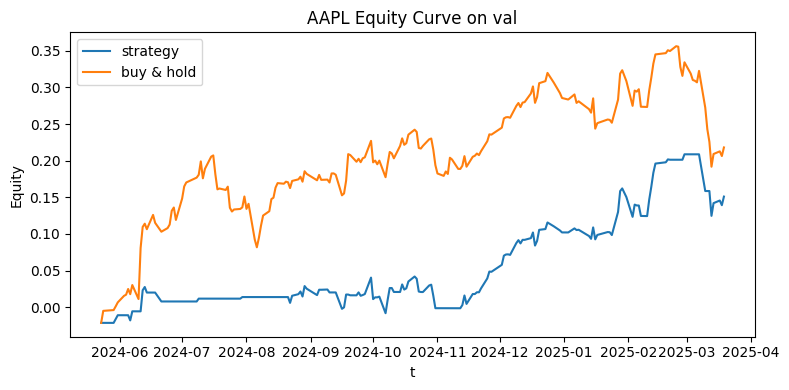

Metrics on val:
Sharpe ratio: 1.5241818249788255, annual return: 0.28269553835673, volatility: 0.18547363163883504


In [6]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["window_size"] = best_params["window_size"]
    del best_params["window_size"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')


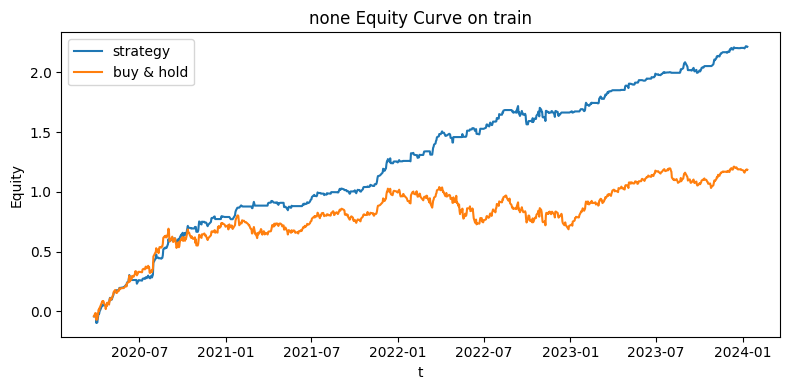

Metrics on train:
Sharpe ratio: 3.335235663177882, annual return: 0.879450141128722, volatility: 0.2636845578374404


In [7]:
data_array, scaled_array, time_array, full_index = prepare_aligned_data(
    CONFIG["ticker"], CONFIG
)

env_train = create_env(data_array, scaled_array, time_array, CONFIG, 'train')

ret, b_h = daily_portfolio_return(env_train, model)

metrics = statistics_calc(ret, b_h, plot=True, mode='train')

Теперь увеличим количество количество шагов обучения до 1_000_000, а также теперь торговать будем по 5-ти минутным барам.

Shape of data: (1628131, 6) 2010-01-04 14:30:00 2025-06-27 20:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_87


Output()

Обучение завершено


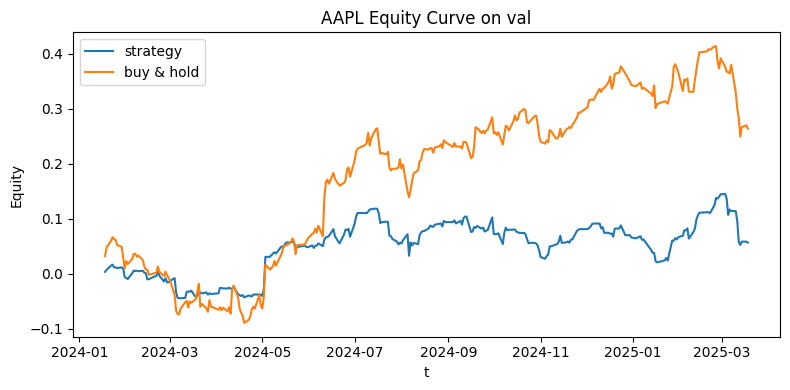

Metrics on val:
Sharpe ratio: 0.41231278273866734, annual return: 0.07370202556390767, volatility: 0.17875270583260475


In [16]:
metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG, interval='5min')

# PPO

In [2]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 50000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None,  # Для одиночного режима
    "optuna": {
        "n_trials": 0,
        "timeout": 72000,  
        "direction": "maximize"
    }
}


In [42]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
def create_env(data, scaled_data, time_data, config, mode='train', n_envs=1, period_override=None):
    """Создает окружение с возможностью переопределения периодов"""
    if period_override:
        start, end = period_override
    else:
        if mode == 'train':
            start, end = config.get("train_period", (None, None))
        elif mode == 'val':
            start, end = config.get("val_period", (None, None))
        elif mode == 'test':
            start, end = config.get("test_period", (None, None))
    
    if start is None or end is None:
        raise ValueError(f"Для режима {mode} не заданы периоды")
    
    mask = (data.index >= start) & (data.index <= end)
    
    # Применяем маску
    data_segment = data[mask]
    scaled_segment = scaled_data[mask]
    time_segment = time_data[mask]
    
    env_kwargs = {
        "data": data_segment[['open', 'high', 'low', 'close']].values.astype(np.float32),
        "scaled_data": scaled_segment.values.astype(np.float32),
        "time_data": time_segment.values.astype(np.float32),
        "window_size": config["window_size"],
        "price_column": config["price_column"],
        "num_actions": config["num_actions"], 
        "timestamps": data_segment.index.values
    }
    
    if n_envs > 1:
        return make_vec_env(
            lambda: StockTradingEnvDSR(**env_kwargs),
            n_envs=n_envs,
            vec_env_cls=SubprocVecEnv,
            seed=config["seed"]
        )
    else:
        return DummyVecEnv([lambda: StockTradingEnvDSR(**env_kwargs)])

def get_model_config(model_type, trial=None):
    base_config = {
        "MLP": {
            "features_extractor_class": MLPFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int('linear_dim', 32, 256) if trial else 64,
                "hidden_layers": [256, 128],
                "dropout": trial.suggest_float('dropout', 0.1, 0.8) if trial else 0.1  # Добавлено условие
            }
        },
        "Linear": {
            "features_extractor_class": LinearFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int('linear_dim', 16, 128) if trial else 32,
            }
        },
        "RNN": {
            "features_extractor_class": RNNFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int('linear_dim', 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int('hidden_dim', 64, 512) if trial else 128  # Добавлено условие
            }
        },
        "LSTM": {
            "features_extractor_class": LSTMExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int('linear_dim', 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int('hidden_dim', 64, 512) if trial else 128  # Добавлено условие
            }
        }
    }
    return base_config.get(model_type, base_config["Linear"])

In [13]:
def train_single_model(config, interval='B', trial=None):
    set_seeds(config["seed"])
    
    raw_data, scaled_data, time_data, _ = prepare_aligned_data(
        config["ticker"], config, interval
    )
    
    # Создаем окружения с использованием периодов из конфига
    env_train = create_env(
        raw_data, scaled_data, time_data, config,
        mode='train', n_envs=5
    )
    env_val = create_env(
        raw_data, scaled_data, time_data, config,
        mode='val', n_envs=1
    )

    # Получаем конфиг экстрактора
    policy_kwargs = get_model_config(config["model_type"], trial)
    
    # Обновляем параметры PPO
    ppo_params = config["ppo_params"].copy()
    ppo_params["policy_kwargs"] = policy_kwargs
    
    model = PPO(
        "MlpPolicy",
        env_train,
        verbose=1,
        **ppo_params
    )
    
    model.learn(total_timesteps=config["total_timesteps"], log_interval=100, callback=ProgressBarCallback())
    
    returns, b_h_ret = daily_portfolio_return(env_val, model)
    metrics = statistics_calc(returns, b_h_ret, plot=True, mode='validation')
    
    return metrics, returns, b_h_ret, model

In [14]:
def sliding_window_training(config, interval='B', trial=None):
    set_seeds(config["seed"])
    window_cfg = config["sliding_window_config"]
    best_agent = None
    all_results = []

    raw_data, scaled_data, time_data, _ = prepare_aligned_data(
        config["ticker"], config, interval
    )
    start_year = window_cfg["start_year"]
    n_windows = window_cfg["n_windows"]
    
    for window_idx in range(n_windows):
        current_year = start_year + window_idx
        print(f"\nОкно {window_idx+1}/{n_windows} (Год: {current_year})")
        
        # Расчет периодов для текущего окна
        train_start = datetime.datetime(current_year, 1, 1)
        train_end = train_start + datetime.timedelta(days=365 * window_cfg["train_years"])
        val_start = train_end
        val_end = val_start + datetime.timedelta(days=365 * window_cfg["val_years"])
        test_start = val_end
        test_end = test_start + datetime.timedelta(days=365 * window_cfg["test_years"])
        
        # Создание окружений
        env_train = create_env(
            raw_data, scaled_data, time_data, config, 
            n_envs=window_cfg["n_envs"],
            period_override=(train_start, train_end)
        )
        
        env_val = create_env(
            raw_data, scaled_data, time_data, config,
            mode='val', n_envs=1,
            period_override=(val_start, val_end)
        )
        
        best_agent_val = None
        best_val_reward = -np.inf
        
        for agent_idx in range(window_cfg["n_agents"]):
            print(f"Обучение агента {agent_idx+1}/{window_cfg['n_agents']}")
            set_seeds(config["seed"] + agent_idx)
            
            # Получаем конфиг экстрактора
            policy_kwargs = get_model_config(config["model_type"], trial)
            
            # Инициализация модели
            if best_agent and window_idx > 0:
                model = PPO(
                    "MlpPolicy",
                    env_train,
                    **config["ppo_params"],
                    policy_kwargs=policy_kwargs
                )
                model.set_parameters(best_agent.get_parameters())
            else:
                model = PPO(
                    "MlpPolicy",
                    env_train,
                    **config["ppo_params"],
                    policy_kwargs=policy_kwargs
                )
            
            # Обучение
            model.learn(total_timesteps=config["total_timesteps"], callback=ProgressBarCallback())
            
            # Оценка
            mean_reward, _ = evaluate_policy(
                model, env_val, n_eval_episodes=1, deterministic=True
            )
            print(f"Агент {agent_idx+1} Средняя награда: {mean_reward:.4f}")
            
            if mean_reward > best_val_reward:
                best_val_reward = mean_reward
                best_agent_val = model
        
        # Тестирование лучшего агента
        env_test = create_env(
            raw_data, scaled_data, time_data, config,
            mode='test', n_envs=1,
            period_override=(test_start, test_end)
        )
        
        returns, b_h_ret = daily_portfolio_return(env_test, best_agent_val)
        metrics = statistics_calc(
            returns, b_h_ret, 
            name=f"Window_{window_idx}", 
            plot=False,
            mode='test',
            ticker=config["ticker"]
        )
        
        all_results.append(metrics)
        best_agent = best_agent_val  # Для следующего окна
        
        # Очистка
        del env_train, env_val, env_test
        torch.cuda.empty_cache()
    
    return pd.concat(all_results)

In [9]:
def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""
    config = CONFIG.copy()
    config["window_size"] = trial.suggest_categorical("window_size", [30, 60, 90, 120, 200])
    config["num_actions"] = trial.suggest_categorical("num_actions", [3, 5, 11, 19, 27])
    config["total_timesteps"] = trial.suggest_categorical("total_timesteps", [30000, 50000, 100000])
    config["ppo_params"]["n_steps"] = trial.suggest_int("n_steps", 128, 2048, step=128)
    # Размер батча для обучения (должен делиться на n_steps)
    config["ppo_params"]["batch_size"] = trial.suggest_categorical("batch_size", [64, 128, 256, 512, 1024, 2048])
    # Число проходов (эпох) по собранному батчу
    config["ppo_params"]["n_epochs"] = trial.suggest_int("n_epochs", 3, 30)
    # Дисконт-фактор
    config["ppo_params"]["gamma"] = trial.suggest_float("gamma", 0.90, 0.9999, step=0.001)
    # Лямбда для GAE
    config["ppo_params"]["gae_lambda"] = trial.suggest_float("gae_lambda", 0.8, 1.0, step=0.01)
    # Диапазон “обрезки” вероятностей
    config["ppo_params"]["clip_range"] = trial.suggest_float("clip_range", 0.1, 0.4, step=0.05)
    # Скорость обучения
    config["ppo_params"]["learning_rate"] = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    # Коэффициент энтропийного бонуса
    config["ppo_params"]["ent_coef"] = trial.suggest_loguniform("ent_coef", 1e-5, 1e-1)
    # Коэффициент потерь value-функции
    config["ppo_params"]["vf_coef"] = trial.suggest_float("vf_coef", 0.1, 1.0, step=0.1)
    # Максимальная норма градиента
    config["ppo_params"]["max_grad_norm"] = trial.suggest_float("max_grad_norm", 0.1, 1.0)
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
                                                                
    min_acceptable_return = 0.05
    all_results = sliding_window_training(config, trial=trial)
    annual_return = all_results["Annual return"].mean()
    sharpe = all_results["Sharpe ratio"].mean()
    vol = all_results["Volatility"].mean()
    if annual_return < min_acceptable_return:
        return annual_return - 1.0
    return 0.7 * all_results["Sharpe ratio"].mean() + 0.3 * all_results["Annual return"].mean() - 0.1 * vol

In [8]:
set_seeds(CONFIG["seed"])
Path("save", "models").parent.mkdir(exist_ok=True)
Path("save", "logs").parent.mkdir(exist_ok=True)

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')
Using cpu device
Logging to logs/PPO_6


Output()

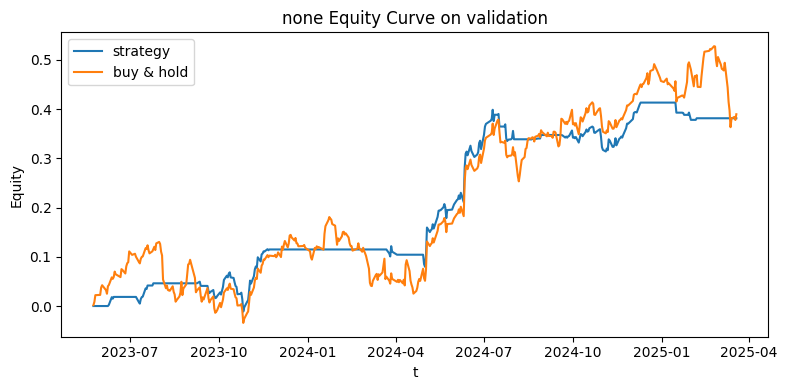

Metrics on validation:
Sharpe ratio: 2.0789844043988084, annual return: 0.3195661235361639, volatility: 0.15371261220623475


In [16]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)

Shape of data: (1628131, 6) 2010-01-04 14:30:00 2025-06-27 20:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')
Using cpu device
Logging to logs/PPO_7


Output()

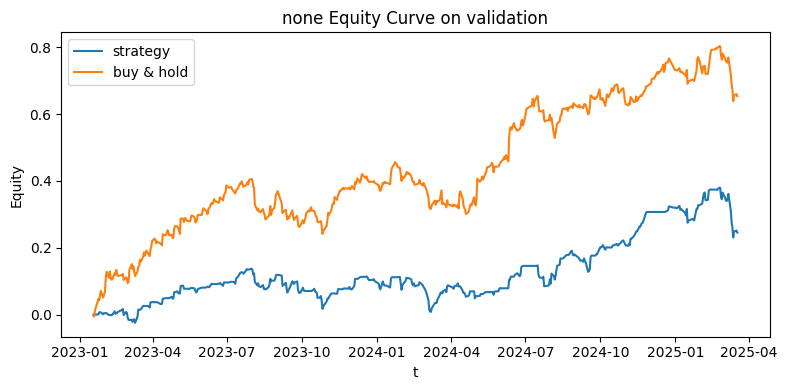

Metrics on validation:
Sharpe ratio: 0.9965321585410957, annual return: 0.17200668357997573, volatility: 0.17260525122620254


In [17]:
metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG, interval='5min')

# Подбор гиперпараметров

В статье [Deep Reinforcement Learning for Optimal Portfolio Allocation: A Comparative
Study with Mean-Variance Optimization](https://icaps23.icaps-conference.org/papers/finplan/FinPlan23_paper_4.pdf), где был был произведен подробный подбор параметров PPO модели. Вот полученный набор из статьи:
- "n_steps": 756
- "batch_size": 1260
- "n_epochs": 16
- "gamma": 0.9
- "gae_lambda": 0.9
- "clip_range": 0.25
- "learning_rate": 3e-4
- "ent_coef": 0.01
- "vf_coef": 0.5
- "max_grad_norm": 0.5

В той статье решалась задача портфельной оптимизации, а мы рассматриваем один актив, поэтому стоит провести свой независимый подбор гиперпараметров.

In [35]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 50000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None,  # Для одиночного режима
    "optuna": {
        "n_trials": 15,
        "timeout": 72000,  
        "direction": "maximize"
    }
}


In [38]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)

[I 2025-07-24 14:03:21,405] A new study created in memory with name: no-name-c2713b29-d4ef-4e79-8289-6e39e13afa68


  0%|          | 0/15 [00:00<?, ?it/s]

Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -32.1803
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 105.7639
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -25.9519

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -13.4814
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -9.2380
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: 93.8318
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -30.0316
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: -91.3535
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -76.5691
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -85.8054

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -20.4966
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 13.6552
Обучение агента 3/3


Агент 3 Средняя награда: -842.9997
[I 2025-07-24 14:14:48,060] Trial 0 finished with value: 0.8519309593656232 and parameters: {'window_size': 60, 'num_actions': 11, 'total_timesteps': 50000, 'n_steps': 512, 'batch_size': 512, 'n_epochs': 20, 'gamma': 0.913, 'gae_lambda': 0.8600000000000001, 'clip_range': 0.2, 'learning_rate': 8.168455894760161e-05, 'ent_coef': 0.013826232179369865, 'vf_coef': 0.2, 'max_grad_norm': 0.5628109945722505, 'linear_dim': 165, 'dropout': 0.1325152889039984, 'hidden_dim': 336}. Best is trial 0 with value: 0.8519309593656232.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 278.4265
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 29.9978
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 33.5513

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 8.0247
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 42.5654
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 53.7530

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -9.9087
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 15.0095
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: 416.9127
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 40.5652
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -54.1347

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 25.4949
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 27.9312
Обучение агента 3/3


Агент 3 Средняя награда: 2.3683
[I 2025-07-24 14:40:53,598] Trial 1 finished with value: 0.6215733274728067 and parameters: {'window_size': 120, 'num_actions': 11, 'total_timesteps': 100000, 'n_steps': 640, 'batch_size': 2048, 'n_epochs': 24, 'gamma': 0.993, 'gae_lambda': 0.98, 'clip_range': 0.30000000000000004, 'learning_rate': 0.0006978281265126031, 'ent_coef': 2.259279742015695e-05, 'vf_coef': 0.2, 'max_grad_norm': 0.14070456001948428, 'linear_dim': 105, 'dropout': 0.3720741027826374, 'hidden_dim': 185}. Best is trial 0 with value: 0.8519309593656232.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 5.6148
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -798.8101
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 30.4863

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -29.8336
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 42.3248
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: 2.2536
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -2.9354
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -4.6139

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -7.6254
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -77.0972
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: -3.4708
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 71.8687
Обучение агента 3/3


Агент 3 Средняя награда: 0.3176
[I 2025-07-24 14:48:51,624] Trial 2 finished with value: 1.1120110672249275 and parameters: {'window_size': 30, 'num_actions': 11, 'total_timesteps': 50000, 'n_steps': 1536, 'batch_size': 1024, 'n_epochs': 12, 'gamma': 0.906, 'gae_lambda': 0.8600000000000001, 'clip_range': 0.2, 'learning_rate': 0.0002878805718308924, 'ent_coef': 0.003550012525851159, 'vf_coef': 0.9, 'max_grad_norm': 0.5249934326457544, 'linear_dim': 58, 'dropout': 0.5992713510560965, 'hidden_dim': 405}. Best is trial 2 with value: 1.1120110672249275.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -8.7355
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 84.2926
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -62.6345

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 67.9180
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -5.7173
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -36.2899

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 55.4581
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -95.5233
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 24.8260

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 1089.1422
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -38.0326
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: 166.6459
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 279.2107
Обучение агента 3/3


Агент 3 Средняя награда: 398.0269
[I 2025-07-24 15:00:50,068] Trial 3 finished with value: 0.9112151640372219 and parameters: {'window_size': 60, 'num_actions': 19, 'total_timesteps': 50000, 'n_steps': 896, 'batch_size': 2048, 'n_epochs': 25, 'gamma': 0.9630000000000001, 'gae_lambda': 0.98, 'clip_range': 0.35, 'learning_rate': 2.3612399244412595e-05, 'ent_coef': 0.03717371747825049, 'vf_coef': 0.6, 'max_grad_norm': 0.8266961396476563, 'linear_dim': 233, 'dropout': 0.32260243248030473, 'hidden_dim': 113}. Best is trial 2 with value: 1.1120110672249275.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 33.9506
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 33.4037
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 35.6069

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 48.0857
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 48.5004
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 59.1260

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 21.9786
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 11.7977
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -89.3075

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -34.9587
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -32.2573
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -21.2815

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 8.4728
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 13.9519
Обучение агента 3/3


Агент 3 Средняя награда: 7.9080
[I 2025-07-24 15:08:03,075] Trial 4 finished with value: 1.2054563769702125 and parameters: {'window_size': 120, 'num_actions': 3, 'total_timesteps': 30000, 'n_steps': 1536, 'batch_size': 128, 'n_epochs': 10, 'gamma': 0.903, 'gae_lambda': 0.92, 'clip_range': 0.25, 'learning_rate': 1.2675278269816288e-05, 'ent_coef': 0.00013019246714361573, 'vf_coef': 1.0, 'max_grad_norm': 0.3156057016002752, 'linear_dim': 64, 'dropout': 0.4426169321942941, 'hidden_dim': 506}. Best is trial 4 with value: 1.2054563769702125.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -18.5751
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -34.4271
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -44.9718

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -2450.1639
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -2458.0454
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -2456.7310

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 1209.5048
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 1205.5898
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 1204.0202

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 22.1520
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 18.3436
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 23.5143

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 1.5507
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -20.4738
Обучение агента 3/3


Агент 3 Средняя награда: -2.3986
[I 2025-07-24 15:15:09,867] Trial 5 finished with value: 0.8305804972543698 and parameters: {'window_size': 90, 'num_actions': 11, 'total_timesteps': 30000, 'n_steps': 128, 'batch_size': 128, 'n_epochs': 7, 'gamma': 0.9690000000000001, 'gae_lambda': 0.88, 'clip_range': 0.4, 'learning_rate': 1.883830778761975e-05, 'ent_coef': 0.00023134781612225627, 'vf_coef': 0.2, 'max_grad_norm': 0.9322242564507065, 'linear_dim': 229, 'dropout': 0.28055913940060895, 'hidden_dim': 360}. Best is trial 4 with value: 1.2054563769702125.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -24.7805
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -52.1125
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 48.8583

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -7.8586
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 30.3720
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 28.6861

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 10.4663
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 7.2611
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 16.8586

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 39.1701
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 58.6749
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 64.7350

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 118.0346
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 89.1065
Обучение агента 3/3


Агент 3 Средняя награда: 63.2675
[I 2025-07-24 15:23:04,511] Trial 6 finished with value: 0.8785571155399038 and parameters: {'window_size': 30, 'num_actions': 5, 'total_timesteps': 50000, 'n_steps': 1664, 'batch_size': 512, 'n_epochs': 5, 'gamma': 0.966, 'gae_lambda': 0.8, 'clip_range': 0.15000000000000002, 'learning_rate': 0.00012516058337570362, 'ent_coef': 0.005855726588796253, 'vf_coef': 0.7000000000000001, 'max_grad_norm': 0.3018423785145038, 'linear_dim': 192, 'dropout': 0.26607436124776007, 'hidden_dim': 210}. Best is trial 4 with value: 1.2054563769702125.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -34.1389
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -39.4530
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: -9.4051
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -2442.5192
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -4.6881

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 1195.8892
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 1206.7365
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 1195.5760

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 2.9278
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -45.4683
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -28.5782

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -27.5887
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 1.4004
Обучение агента 3/3


Агент 3 Средняя награда: -37.9018
[I 2025-07-24 15:31:32,298] Trial 7 finished with value: 1.20514946050551 and parameters: {'window_size': 90, 'num_actions': 27, 'total_timesteps': 50000, 'n_steps': 1664, 'batch_size': 1024, 'n_epochs': 3, 'gamma': 0.964, 'gae_lambda': 0.8300000000000001, 'clip_range': 0.4, 'learning_rate': 0.0008088298191148202, 'ent_coef': 0.04565176372646328, 'vf_coef': 0.4, 'max_grad_norm': 0.11391095487598069, 'linear_dim': 240, 'dropout': 0.3997289038221201, 'hidden_dim': 498}. Best is trial 4 with value: 1.2054563769702125.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -66.2682
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -62.7629
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -41.6053

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 35.2424
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 14.4032
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: -13.9706
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 10.0274
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -27.9685

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 43.2368
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 371.3898
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: 38.8969
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 65.6423
Обучение агента 3/3


Агент 3 Средняя награда: 159.3224
[I 2025-07-24 15:51:58,910] Trial 8 finished with value: 0.5033245033538308 and parameters: {'window_size': 30, 'num_actions': 19, 'total_timesteps': 100000, 'n_steps': 2048, 'batch_size': 256, 'n_epochs': 13, 'gamma': 0.929, 'gae_lambda': 0.9600000000000001, 'clip_range': 0.35, 'learning_rate': 0.0005421814280975645, 'ent_coef': 0.04497407193749842, 'vf_coef': 0.6, 'max_grad_norm': 0.5513646652184797, 'linear_dim': 211, 'dropout': 0.5549747515444357, 'hidden_dim': 379}. Best is trial 4 with value: 1.2054563769702125.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -34.3874
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 256.9156
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 247.9692

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -30.4897
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -19.0246
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -34.0441

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 14.0567
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 165.2381
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 29.0887

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -48.3629
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -57.1353
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -60.8894

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 48.6470
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 40.2095
Обучение агента 3/3


Агент 3 Средняя награда: 41.0852
[I 2025-07-24 15:56:43,779] Trial 9 finished with value: 1.2514208542395204 and parameters: {'window_size': 60, 'num_actions': 3, 'total_timesteps': 30000, 'n_steps': 1792, 'batch_size': 512, 'n_epochs': 5, 'gamma': 0.905, 'gae_lambda': 0.91, 'clip_range': 0.25, 'learning_rate': 0.0001883041116446473, 'ent_coef': 0.008023527304678842, 'vf_coef': 1.0, 'max_grad_norm': 0.5646703134710758, 'linear_dim': 104, 'dropout': 0.6566303363380926, 'hidden_dim': 185}. Best is trial 9 with value: 1.2514208542395204.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -15.0828
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -36.1699
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -15.9342

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 26.4467
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 26.8790
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 22.9017

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -1.8828
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 124.9065
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -10.0422

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -10.8881
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 16.3938
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -15.3626

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -243.9739
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 4.9584
Обучение агента 3/3


Агент 3 Средняя награда: 10.9647
[I 2025-07-24 16:14:16,944] Trial 10 finished with value: 0.4995123896608288 and parameters: {'window_size': 200, 'num_actions': 3, 'total_timesteps': 30000, 'n_steps': 2048, 'batch_size': 64, 'n_epochs': 18, 'gamma': 0.936, 'gae_lambda': 0.93, 'clip_range': 0.1, 'learning_rate': 7.218926081259325e-05, 'ent_coef': 0.0007581975333807081, 'vf_coef': 0.8, 'max_grad_norm': 0.7294921408642425, 'linear_dim': 118, 'dropout': 0.7949132721341801, 'hidden_dim': 77}. Best is trial 9 with value: 1.2514208542395204.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 29.2121
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 32.9931
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 37.2100

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 923.0233
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 937.7433
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 92.2938

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 565.1536
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -42.0723
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: -20.8064
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -6.9129
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -8.9030

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -11.1578
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -2.6144
Обучение агента 3/3


Агент 3 Средняя награда: -3.9581
[I 2025-07-24 16:20:59,778] Trial 11 finished with value: 0.5182791139675569 and parameters: {'window_size': 120, 'num_actions': 3, 'total_timesteps': 30000, 'n_steps': 1408, 'batch_size': 128, 'n_epochs': 9, 'gamma': 0.903, 'gae_lambda': 0.92, 'clip_range': 0.25, 'learning_rate': 1.1672711987380448e-05, 'ent_coef': 7.944756246019571e-05, 'vf_coef': 1.0, 'max_grad_norm': 0.3642547223103561, 'linear_dim': 32, 'dropout': 0.5729330576947287, 'hidden_dim': 247}. Best is trial 9 with value: 1.2514208542395204.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -28.3326
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -21.4621
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 248.1353

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 145.4229
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -27.3032
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 63.3434

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 142.9482
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 83.6974
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: -19.9968
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -77.9534
Обучение агента 3/3


Output()

Output()

Агент 1 Средняя награда: 24.0405
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 1.2388
Обучение агента 3/3


Агент 3 Средняя награда: 115.9898
[I 2025-07-24 16:26:31,024] Trial 12 finished with value: 0.6733604154698958 and parameters: {'window_size': 60, 'num_actions': 3, 'total_timesteps': 30000, 'n_steps': 1152, 'batch_size': 512, 'n_epochs': 11, 'gamma': 0.92, 'gae_lambda': 0.91, 'clip_range': 0.25, 'learning_rate': 0.00020065771485986705, 'ent_coef': 0.0008734555018893361, 'vf_coef': 1.0, 'max_grad_norm': 0.3738958274756948, 'linear_dim': 80, 'dropout': 0.7579753649560657, 'hidden_dim': 499}. Best is trial 9 with value: 1.2514208542395204.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 0.1438
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 28.0366
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 25.9860

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 38.1996
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -17.6934
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 192.2315

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 30.4962
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 52.6188
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 38.8666

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 3.0246
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -27.0679
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -36.9381

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -2.8038
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 11.4741
Обучение агента 3/3


Агент 3 Средняя награда: 4.6583
[I 2025-07-24 16:42:37,067] Trial 13 finished with value: 1.5140690816334297 and parameters: {'window_size': 120, 'num_actions': 3, 'total_timesteps': 30000, 'n_steps': 1280, 'batch_size': 128, 'n_epochs': 30, 'gamma': 0.9440000000000001, 'gae_lambda': 0.9400000000000001, 'clip_range': 0.30000000000000004, 'learning_rate': 4.6149277258891906e-05, 'ent_coef': 1.1158405702940466e-05, 'vf_coef': 0.8, 'max_grad_norm': 0.6914307738948051, 'linear_dim': 135, 'dropout': 0.495171410542586, 'hidden_dim': 153}. Best is trial 13 with value: 1.5140690816334297.


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -16.9130
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -7.2884
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -47.3224

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 22.9881
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 110.4262
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 103.2956

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 19.4840
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 0.0000
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 0.0000

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -12.1728
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -40.1717
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -227.8962

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 5.8524
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 69.1997
Обучение агента 3/3


Агент 3 Средняя награда: -297.6652
[I 2025-07-24 17:11:35,676] Trial 14 finished with value: -1.2775025774515634 and parameters: {'window_size': 200, 'num_actions': 3, 'total_timesteps': 30000, 'n_steps': 1152, 'batch_size': 64, 'n_epochs': 29, 'gamma': 0.933, 'gae_lambda': 0.9500000000000001, 'clip_range': 0.30000000000000004, 'learning_rate': 4.479035127356784e-05, 'ent_coef': 2.003571282095069e-05, 'vf_coef': 0.8, 'max_grad_norm': 0.7024231104589974, 'linear_dim': 144, 'dropout': 0.6731297866574906, 'hidden_dim': 150}. Best is trial 13 with value: 1.5140690816334297.
Лучшие параметры: {'window_size': 120, 'num_actions': 3, 'total_timesteps': 30000, 'n_steps': 1280, 'batch_size': 128, 'n_epochs': 30, 'gamma': 0.9440000000000001, 'gae_lambda': 0.9400000000000001, 'clip_range': 0.30000000000000004, 'learning_rate': 4.6149277258891906e-05, 'ent_coef': 1.1158405702940466e-05, 'vf_coef': 0.8, 'max_grad_norm': 0.6914307738948051, 'linear_dim': 135, 'dropout': 0.495171410542586, 'hidden_dim

In [39]:
print(f"Лучшие параметры: {best_params}")
print(f"Лучшая награда: {study.best_value}")

Лучшие параметры: {'window_size': 120, 'num_actions': 3, 'total_timesteps': 30000, 'n_steps': 1280, 'batch_size': 128, 'n_epochs': 30, 'gamma': 0.9440000000000001, 'gae_lambda': 0.9400000000000001, 'clip_range': 0.30000000000000004, 'learning_rate': 4.6149277258891906e-05, 'ent_coef': 1.1158405702940466e-05, 'vf_coef': 0.8, 'max_grad_norm': 0.6914307738948051, 'linear_dim': 135, 'dropout': 0.495171410542586, 'hidden_dim': 153}
Лучшая награда: 1.5140690816334297


In [40]:
def update_config(old_dct, new_dct):
    for key, value in old_dct.items():
        if key in new_dct:
            old_dct[key] = new_dct[key]
        else:
            if isinstance(value, dict):
                update_config(value, new_dct)

In [41]:
update_config(CONFIG, best_params)
print(CONFIG)

{'ticker': 'AAPL', 'model_type': 'Linear', 'window_size': 120, 'price_column': 3, 'num_actions': 3, 'training_mode': 'single', 'sliding_window_config': {'train_years': 5, 'val_years': 1, 'test_years': 1, 'start_year': 2010, 'n_windows': 5, 'n_envs': 1, 'n_agents': 3}, 'seed': 42, 'ppo_params': {'n_steps': 1280, 'batch_size': 128, 'n_epochs': 30, 'gamma': 0.9440000000000001, 'gae_lambda': 0.9400000000000001, 'clip_range': 0.30000000000000004, 'learning_rate': 4.6149277258891906e-05, 'ent_coef': 1.1158405702940466e-05, 'vf_coef': 0.8, 'max_grad_norm': 0.6914307738948051, 'tensorboard_log': 'logs/'}, 'total_timesteps': 30000, 'train_period': ('2010-11-13', '2023-01-11'), 'val_period': ('2023-01-11', '2025-03-19'), 'test_period': None, 'optuna': {'n_trials': 15, 'timeout': 72000, 'direction': 'maximize'}}


In [43]:
metrics = sliding_window_training(CONFIG)

Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 35.4461
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 32.0447
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 15.7764

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 0.0000
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 2.7923
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 245.3961

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 22.5611
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -33.1169
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 49.3467

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 42.3769
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -29.2156
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 41.4943

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -10.0659
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 0.0000
Обучение агента 3/3


Агент 3 Средняя награда: 0.0565


In [44]:
metrics

,Sharpe ratio,Annual return,Volatility
Window_0,2.858459,0.410019,0.143440
Window_1,1.219245,0.214453,0.175890
Window_2,0.296491,0.078290,0.264057
Window_3,1.791999,0.243388,0.135819
Window_4,2.362815,0.723674,0.306276


In [45]:
print('Metrics on the best params')
print(f'Mean Sharpe ratio on {CONFIG['ticker']}: {metrics['Sharpe ratio'].mean()}, mean Annual return: {metrics['Annual return'].mean()}, mean Volatility: {metrics['Volatility'].mean()}')

Metrics on the best params
Mean Sharpe ratio on AAPL: 1.7058018649291964, mean Annual return: 0.333964799057034, mean Volatility: 0.20509651473357535


# Запуск модели на других активах

In [46]:
CONFIG['ticker'] = 'MSFT'

In [47]:
metrics = sliding_window_training(CONFIG)

Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -29.4282
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 38.9759
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -61.4807

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 0.0000
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 0.0000
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 0.0000

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 0.0000
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 0.0000
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 0.0000

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 2.1226
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -8.8707
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -6.8856

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -13.1127
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -9.7391
Обучение агента 3/3


Агент 3 Средняя награда: 0.0000


In [48]:
metrics

,Sharpe ratio,Annual return,Volatility
Window_0,NaN,0.000000,0.000000
Window_1,NaN,0.000000,0.000000
Window_2,0.566357,0.038371,0.067751
Window_3,NaN,0.000000,0.000000
Window_4,-0.750051,-0.076694,0.102252


In [49]:
print(f'Mean Sharpe ratio on {CONFIG['ticker']}: {metrics['Sharpe ratio'].mean()}, mean Annual return: {metrics['Annual return'].mean()}, mean Volatility: {metrics['Volatility'].mean()}')

Mean Sharpe ratio on MSFT: -0.09184722117110561, mean Annual return: -0.0076645033292996444, mean Volatility: 0.03400062149323069


In [50]:
CONFIG['ticker'] = 'AMZN'

In [51]:
metrics = sliding_window_training(CONFIG)

Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00 2025-06-27 00:00:00
feature finance: Index(['f_log_ret', 'f_vol20', 'f_vol60', 'f_vol20/vol60', 'f_ema_10',
       'f_ema_20', 'f_rsi', 'f_macd_line', 'f_macd_signal'],
      dtype='object')
feature time: Index(['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
       'quarter_sin', 'quarter_cos', 'is_month_end'],
      dtype='object')

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 138.0190
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 90.8369
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 124.3616

Окно 2/5 (Год: 2011)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -5.0856
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 76.4742
Обучение агента 3/3


Output()

Агент 3 Средняя награда: -42.4924

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -34.0005
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 16.2467
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 12.2381

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 54.9573
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 24.0821
Обучение агента 3/3


Output()

Агент 3 Средняя награда: 58.3649

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 6.3194
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -0.7164
Обучение агента 3/3


Агент 3 Средняя награда: -26.4397


In [52]:
metrics

,Sharpe ratio,Annual return,Volatility
Window_0,0.227445,0.055830,0.245467
Window_1,-0.226399,-0.039330,0.173722
Window_2,0.053265,0.012921,0.242581
Window_3,-1.108653,-0.163844,0.147787
Window_4,0.699271,0.172061,0.246057


In [56]:
print(f'Mean Sharpe ratio on {CONFIG['ticker']}: {metrics['Sharpe ratio'].mean()}, mean Annual return: {metrics['Annual return'].mean()}, mean Volatility: {metrics['Volatility'].mean()}')

Mean Sharpe ratio on AMZN: -0.0710142562211464, mean Annual return: 0.007527376093570709, mean Volatility: 0.2111226273981051
